## **Week 3: Understanding Neural Networks**
### José Manuel López, Alex Martín, Marcos V. Conde

### **Goals**
* Understanding the MLP topology.
* Learn how to extract features from a network.
* Compare learnt features vs with handcrafted features.

### **Experimentation**
* MLP on small images: end to end VS SVM.
    * Different structures: adding layers, image size, etc.
    * Extract features from the output of the last layer and use them as descriptor on SVM
* MLP as dense descriptor: end to end VS BoW.
    * Divide the image into small patches and extract the prediction for each patch and aggregate the final prediction.
    * Take each patch output and apply BoW.

### **Tasks**
<ins>Understanding Networks</ins>
1.  Add/Change layers in NN topology.
2.  Given an image, get the output of a given layer.
3.  Manage to merge multiple outputs from a single image in a end to end network.

<ins>Learnt vs Handcrafted </ins>

4.  Extract a single feature from an input and apply to svm, compare to end to end network.
5.  Extract multiple features from and image and apply BoW, compare to end to end network.

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
try:
    from keras.utils import plot_model
except:
    from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras import mixed_precision

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices()[1].physical_device_desc)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:26:00.0, compute capability: 8.6
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [4]:
# DEFAULT VARIABLES
colab = False
IMG_SIZE = 32
BATCH_SIZE = 16
EPOCHS = 50
RANDOM_SEED = 42
DATASET_DIR = './MIT_split'
if colab:
  DATASET_DIR = '/content/drive/MyDrive/MIT_split'

# SET SEED TO CONTROL RANDOMNESS
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
def get_datasets():
        # this is the dataset configuration we will use for training
        # only rescaling
        train_datagen = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True)

        # this is the dataset configuration we will use for testing:
        # only rescaling
        test_datagen = ImageDataGenerator(rescale=1./255)

        # this is a generator that will read pictures found in
        # subfolers of 'data/train', and indefinitely generate
        # batches of augmented image data
        train_loader = train_datagen.flow_from_directory(
                DATASET_DIR+'/train',  # this is the target directory
                target_size=(IMG_SIZE, IMG_SIZE),  # all images will be resized to IMG_SIZExIMG_SIZE
                batch_size=BATCH_SIZE,
                classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
                class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

        # this is a similar generator, for validation data
        test_loader = test_datagen.flow_from_directory(
                DATASET_DIR+'/test',
                target_size=(IMG_SIZE, IMG_SIZE),
                batch_size=BATCH_SIZE,
                classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
                class_mode='categorical')
        
        return train_loader, test_loader

train_loader, test_loader = get_datasets()

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.


In [6]:
type(train_loader)

keras.preprocessing.image.DirectoryIterator

In [7]:
# Testing DataLoader and Data Cardinality
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

(16, 32, 32, 3)

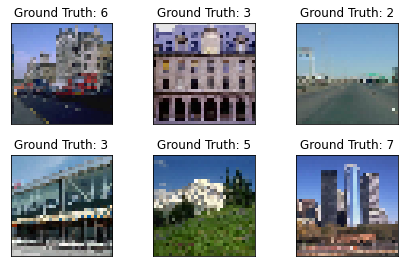

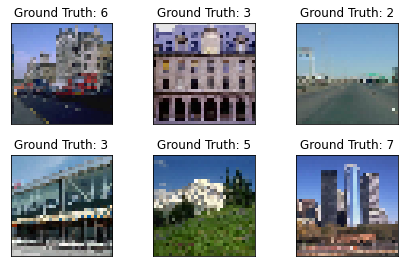

In [8]:
# Plotting some Data to know more about the Dataset
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(np.argmax(example_targets[i])))
  plt.xticks([])
  plt.yticks([])
fig

In [9]:
def build_model(layers, file, info = True, IMG_SIZE=IMG_SIZE):
    model = Sequential()
    model.add(Reshape((IMG_SIZE*IMG_SIZE*3,),input_shape=(IMG_SIZE, IMG_SIZE, 3),name='Flatten'))
    for layer in layers:
        model.add(layer)
    model.add(Dense(units=8, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if info:
        print(model.summary())
        plot_model(model, to_file=file, show_shapes=True, show_layer_names=True)
    return model

model = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu', name="features")], 'modelMLP_1.png')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
features (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 8200      
Total params: 12,596,232
Trainable params: 12,596,232
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
history = model.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE)

Epoch 1/50
117/117 [==============================] - 6s 36ms/step - loss: 2.4030 - accuracy: 0.1995 - val_loss: 1.7282 - val_accuracy: 0.3625
Epoch 2/50
117/117 [==============================] - 4s 35ms/step - loss: 1.6872 - accuracy: 0.3646 - val_loss: 1.6572 - val_accuracy: 0.3500
Epoch 3/50
117/117 [==============================] - 4s 36ms/step - loss: 1.6201 - accuracy: 0.3748 - val_loss: 1.7206 - val_accuracy: 0.3438
Epoch 4/50
117/117 [==============================] - 4s 34ms/step - loss: 1.5352 - accuracy: 0.4236 - val_loss: 1.5297 - val_accuracy: 0.4325
Epoch 5/50
117/117 [==============================] - 4s 34ms/step - loss: 1.4754 - accuracy: 0.4456 - val_loss: 1.4752 - val_accuracy: 0.4712
Epoch 6/50
117/117 [==============================] - 4s 33ms/step - loss: 1.4242 - accuracy: 0.4863 - val_loss: 1.5083 - val_accuracy: 0.4563
Epoch 7/50
117/117 [==============================] - 4s 34ms/step - loss: 1.3086 - accuracy: 0.5367 - val_loss: 1.4149 - val_accuracy: 0.5150

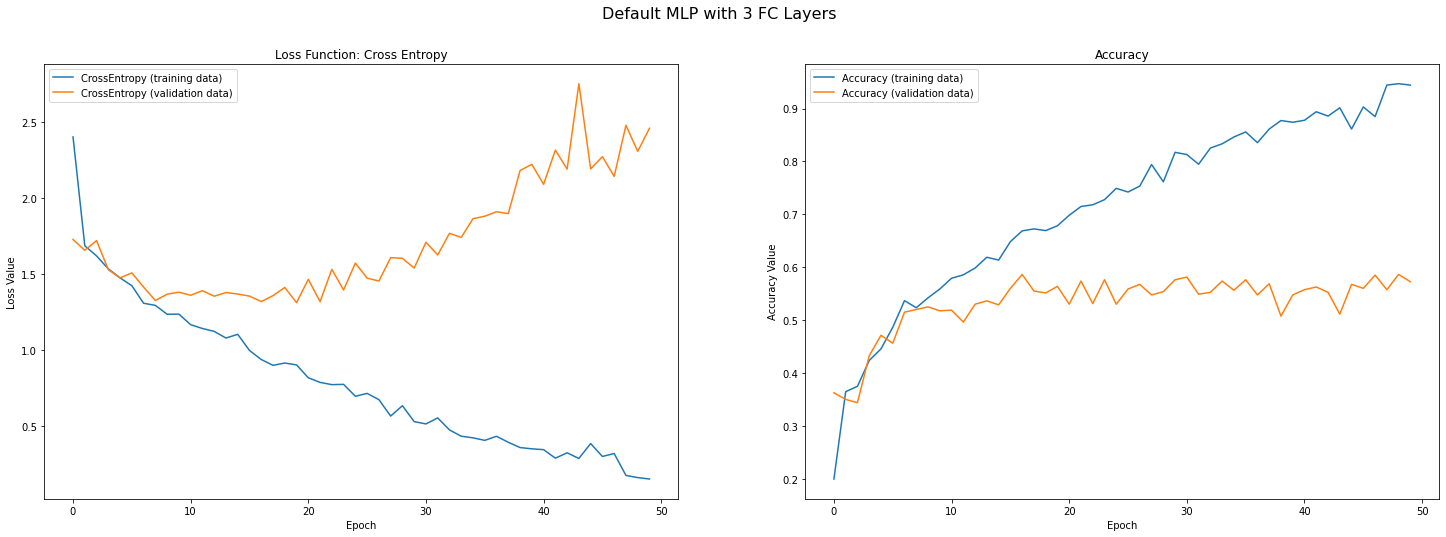

In [11]:
def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

plot_loss_accuracy(history, 'Default MLP with 3 FC Layers')

In [12]:
def evaluate_model(model,title):
    print("---"*30)
    loss, score = model.evaluate(train_loader, verbose = 0)
    print("{} Train Score: {:.3f} || Train Loss: {:.3f}".format(title,100*score, loss))
    loss, score = model.evaluate(test_loader, verbose = 0)
    print("{} Test Score: {:.3f} || Test Loss: {:.3f}".format(title,100*score, loss))
    print("---"*30)


### Evaluating changes in Network Topology
We are going to evaluate those changes using different number of layers and different number of neurons. Then Accuracy and Loss through epochs will be displayed for both training and test datasets.

* The first experiment will be increasing the number of layers. We have 3 FC layers at default MLP: we are going to add 4, 5, 6 layers and see the results.
    * We follow a power of 2 rule (32, 64, 128, 256, ...) for the number of neurons.

In [13]:
# 6 FC layers
model_6 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=256, activation='relu'), Dense(units=128, activation='relu'), Dense(units=64, activation='relu'), Dense(units=32, activation='relu', name="features")], 'modelMLP_6.png')

# Training
history_6 = model_6.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [14]:
# 5 FC layers
model_5 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=256, activation='relu'), Dense(units=128, activation='relu'), Dense(units=64, activation='relu', name="features")], 'modelMLP_5.png')

# Training
history_5 = model_5.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
features (Dense)             (None, 64)               

In [15]:
# 4 FC layers
model_4 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=256, activation='relu'), Dense(units=128, activation='relu', name="features")], 'modelMLP_4.png')
# Training
history_4 = model_4.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
features (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_20 (Dense)             (None, 8)                

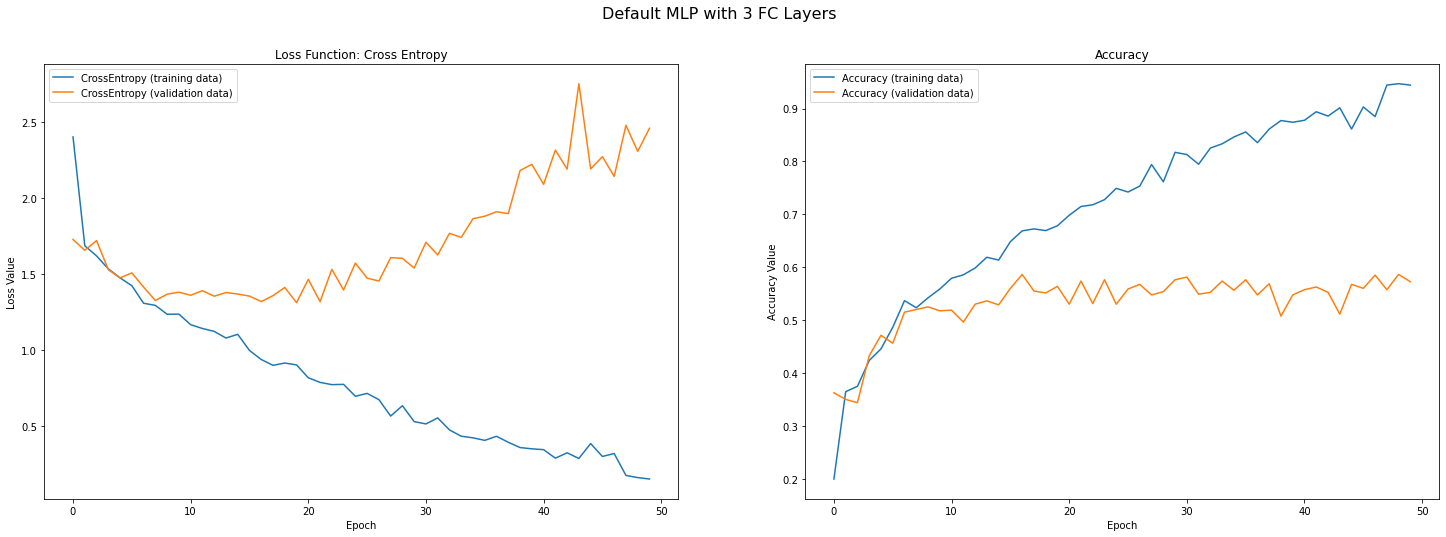

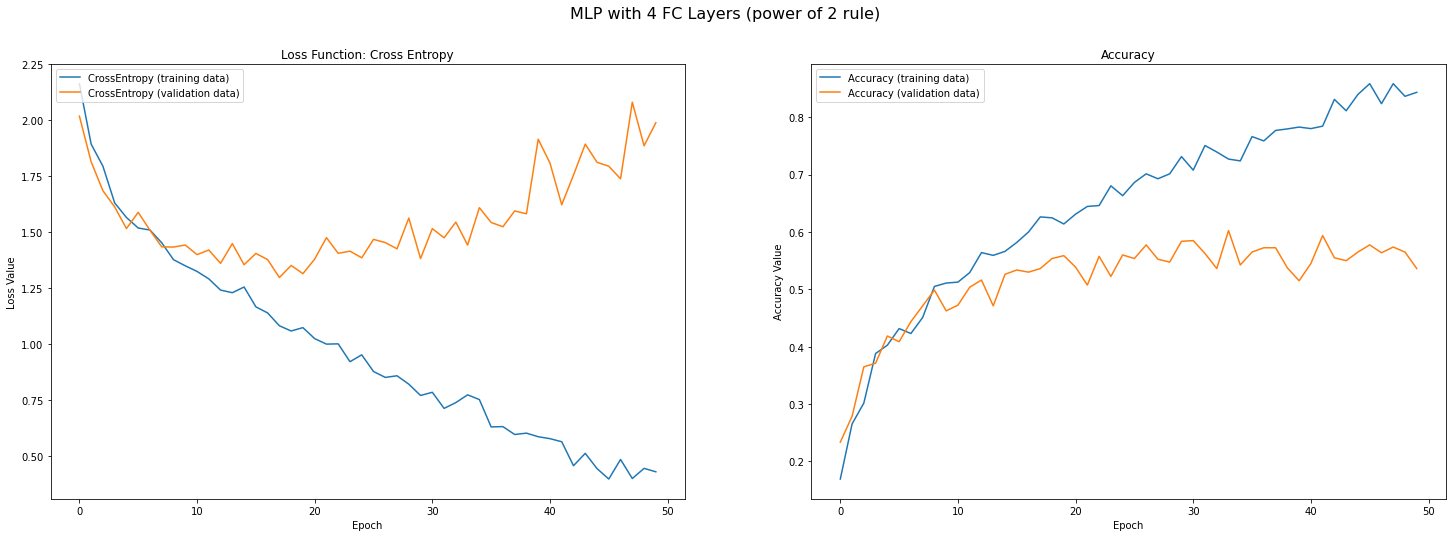

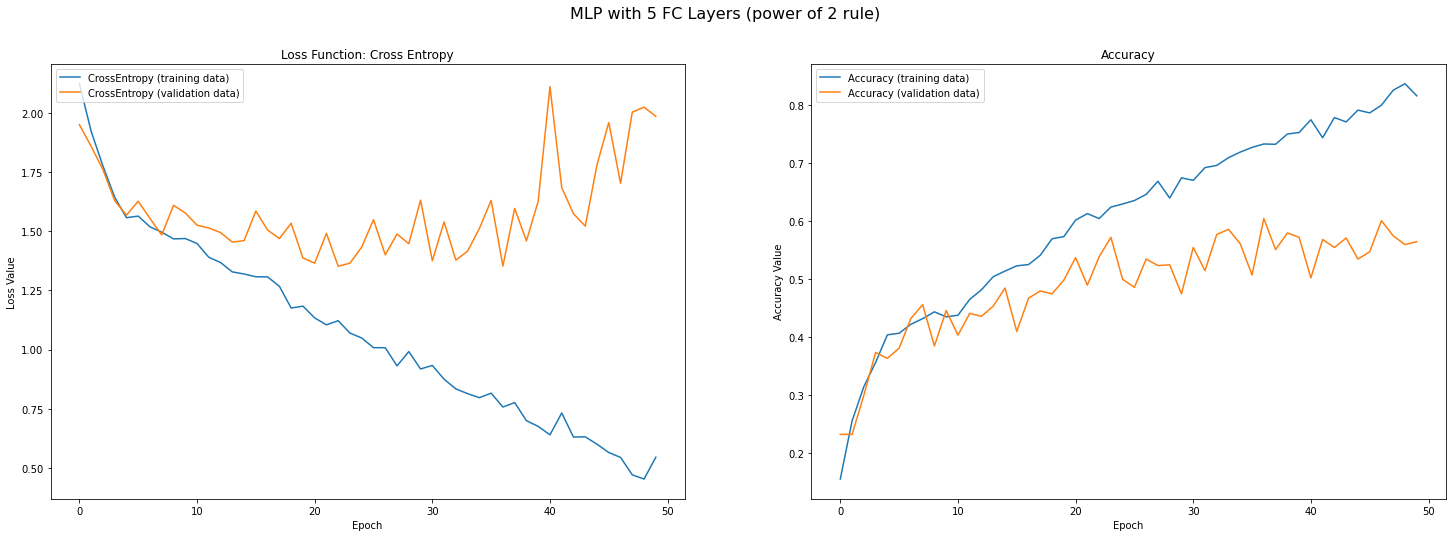

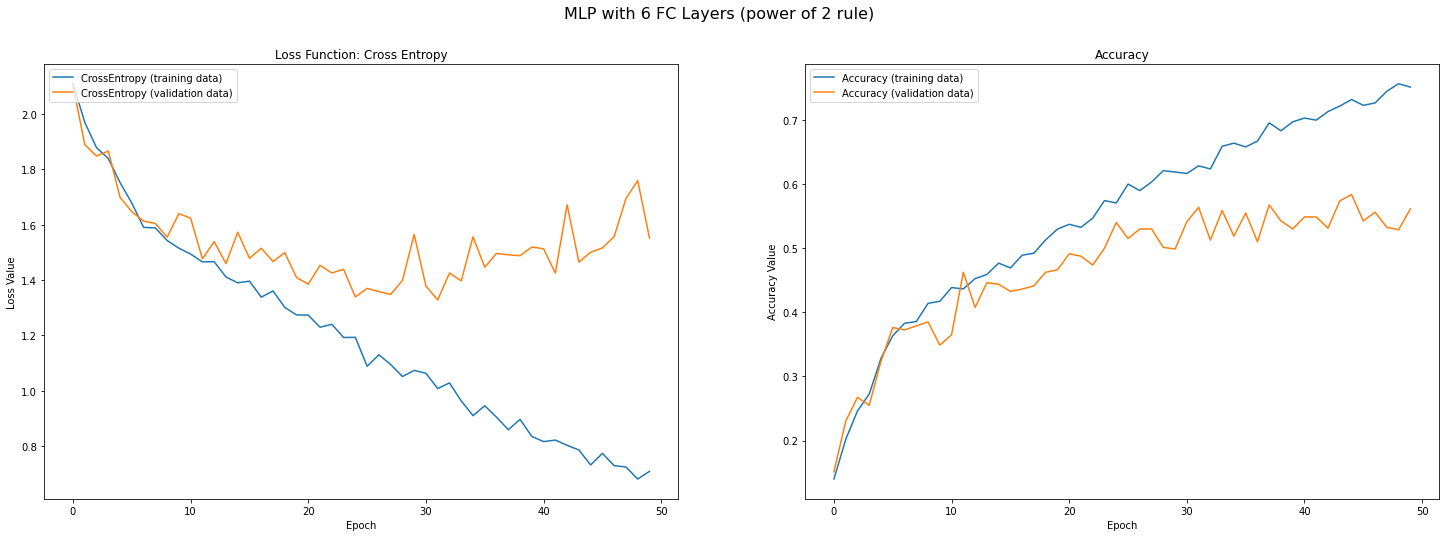

In [16]:
plot_loss_accuracy(history, 'Default MLP with 3 FC Layers')
plot_loss_accuracy(history_4, 'MLP with 4 FC Layers (power of 2 rule)')
plot_loss_accuracy(history_5, 'MLP with 5 FC Layers (power of 2 rule)')
plot_loss_accuracy(history_6, 'MLP with 6 FC Layers (power of 2 rule)')

In [17]:
evaluate_model(model, "Default (Model 3)")
evaluate_model(model_4, "Model 4")
evaluate_model(model_5, "Model 5")
evaluate_model(model_6, "Model 6")

------------------------------------------------------------------------------------------
Default (Model 3) Train Score: 98.246 || Train Loss: 0.066
Default (Model 3) Test Score: 57.249 || Test Loss: 2.472
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 4 Train Score: 82.988 || Train Loss: 0.450
Model 4 Test Score: 53.532 || Test Loss: 2.008
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 5 Train Score: 78.628 || Train Loss: 0.635
Model 5 Test Score: 56.877 || Test Loss: 1.970
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 6 Train Score: 75.651 || Train Loss: 0.678
Model 


*   Now we are going to try the same number of layers but increasing the dense layers (instead of 1024, 512, 128, 64, ... we go for 1024, 1024, 1024, ...).

In [18]:
# Default but more density depth
model_4_big = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu', name="features")], 'modelMLP_4_big.png')
# Training
history_4_big = model_4_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_22 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
features (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 8200      
Total params: 13,645,832
Trainable params: 13,645,832
Non-trainable params: 0
__________________________________________

In [19]:
# Default but more density depth
model_5_big = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu'),
                           Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu', name="features")], 'modelMLP_5_big.png')
# Training
history_5_big = model_5_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_26 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
features (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_29 (Dense)             (None, 8)                

In [20]:
# Default but more density depth
model_6_big = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu'),
                           Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu', name="features")], 'modelMLP_6_big.png')
# Training
history_6_big = model_6_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_31 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
features (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_34 (Dense)             (None, 8)                

In [21]:
# Default but more density depth
model_10_big = build_model([Dense(units=1024, activation='relu') for i in range(9)]+[Dense(units=1024, activation='relu', name="features")], 'modelMLP_10_big.png')
# Training
history_10_big = model_10_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_40 (Dense)             (None, 1024)             

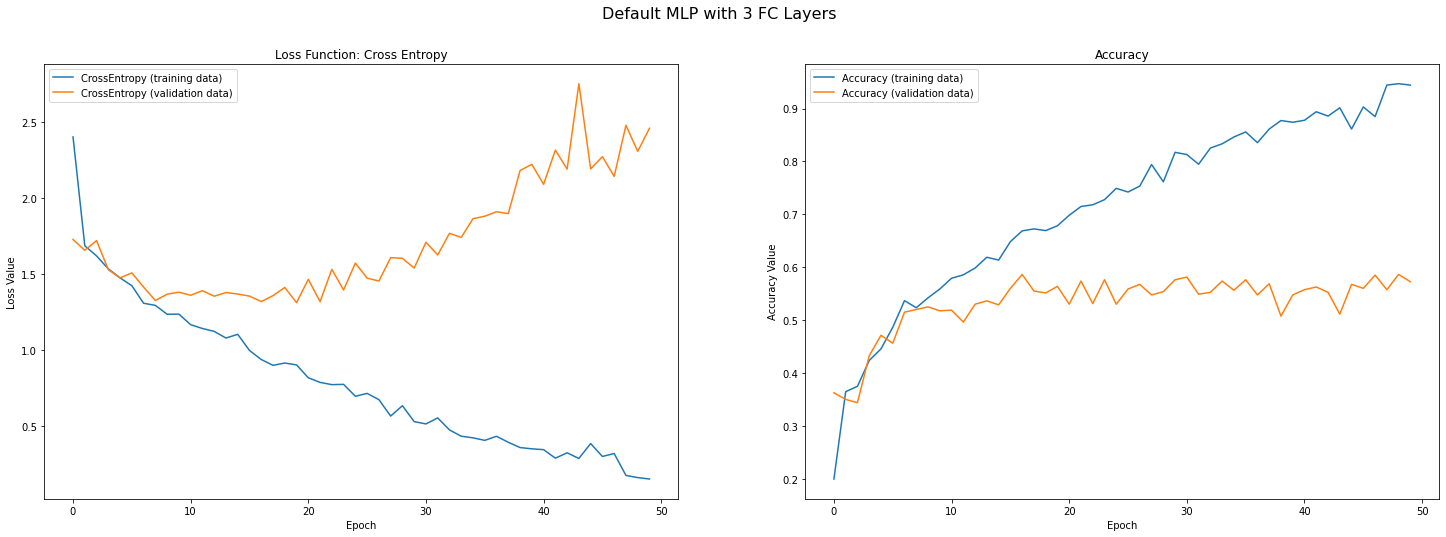

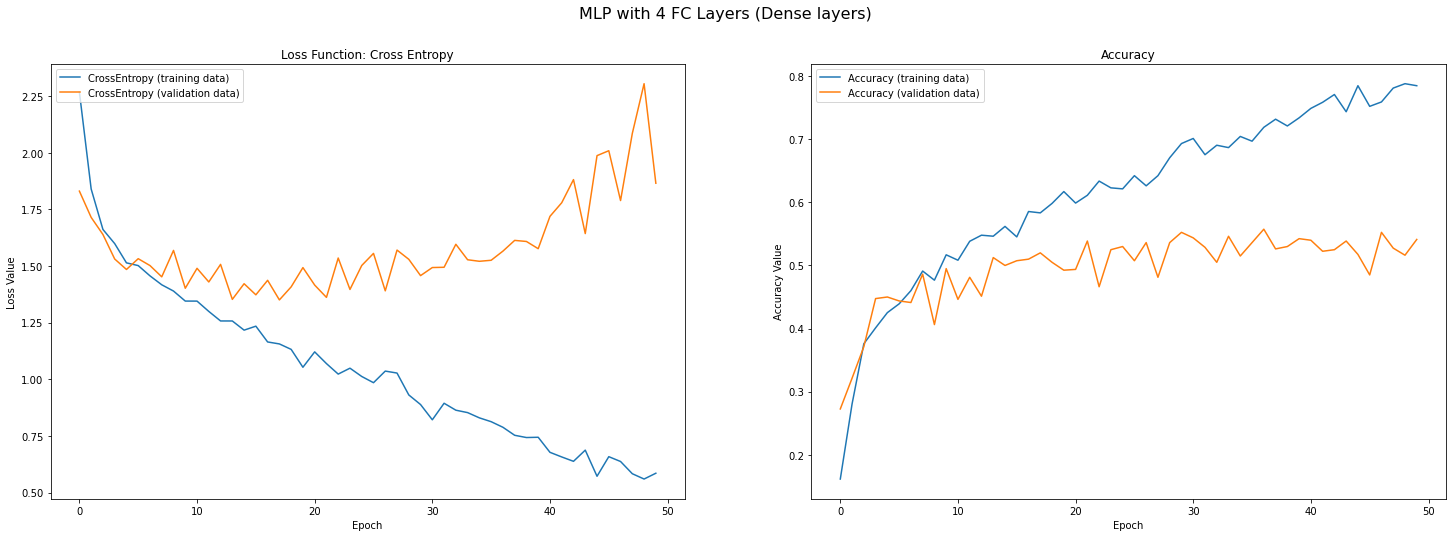

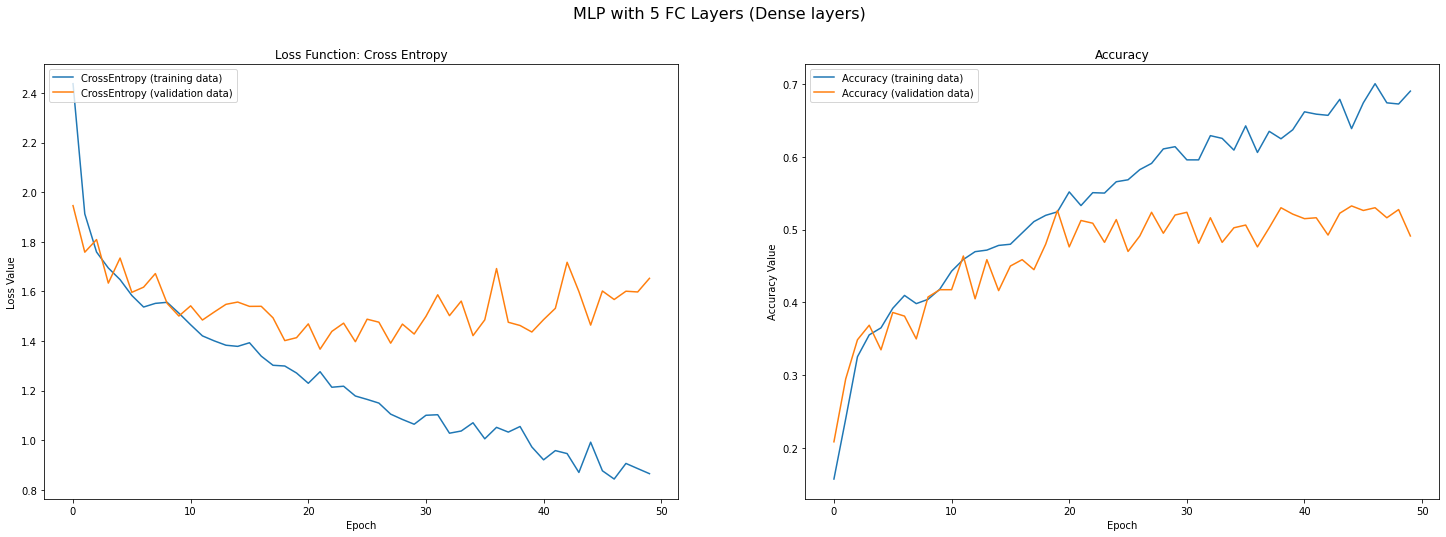

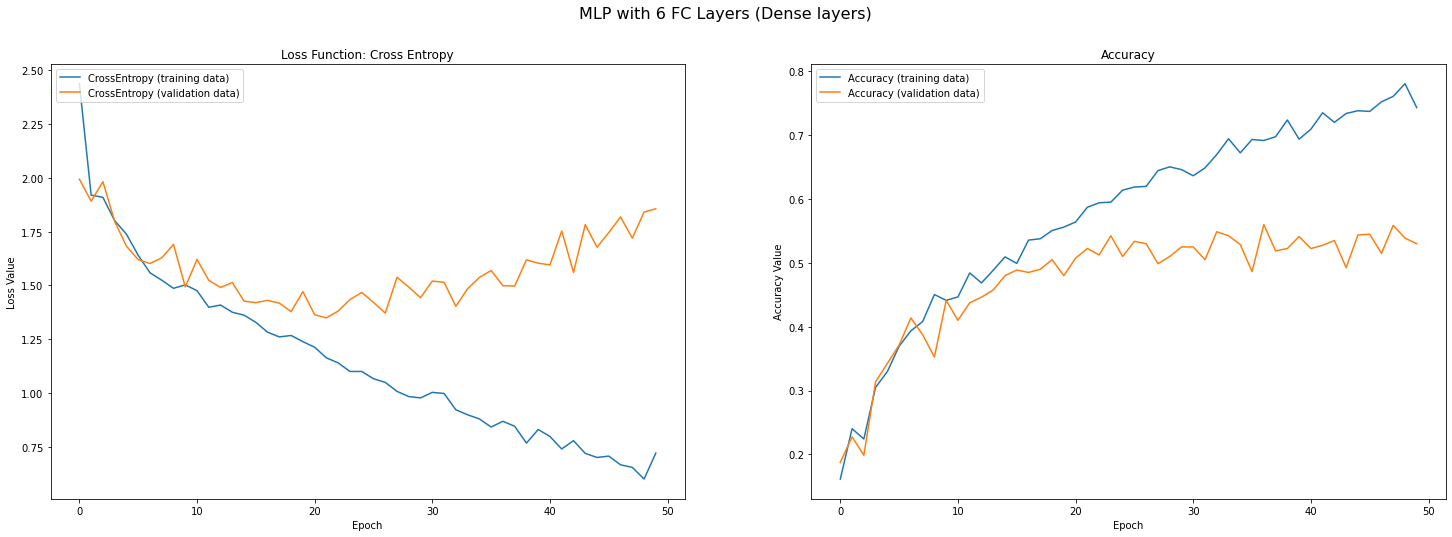

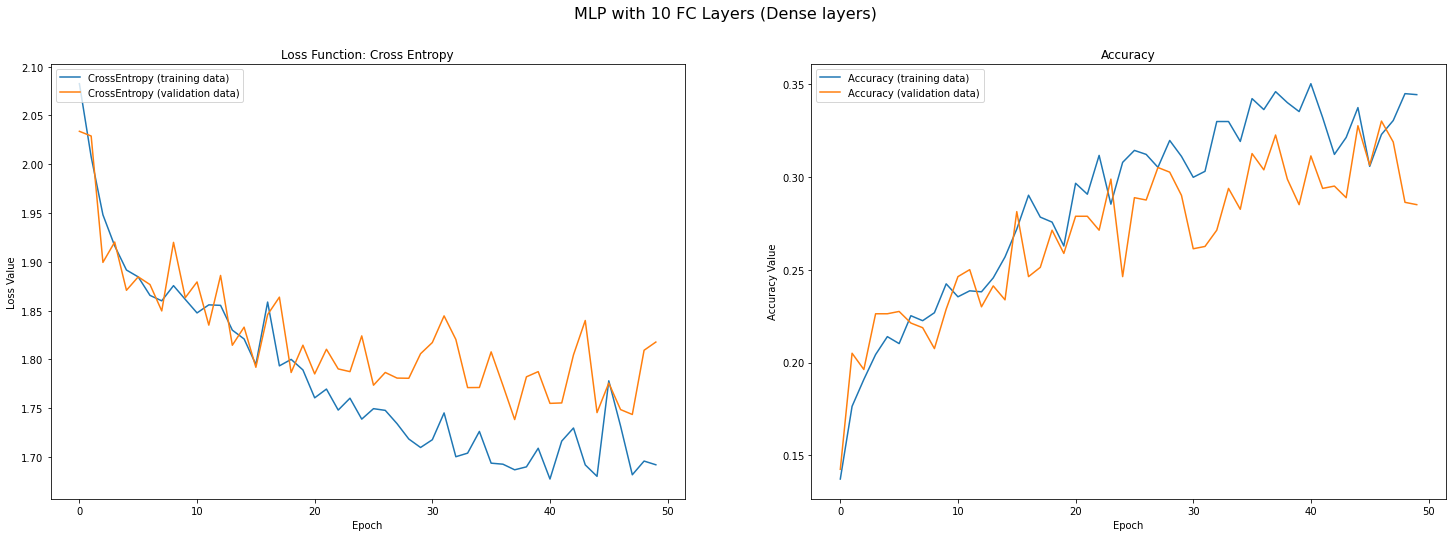

In [22]:
plot_loss_accuracy(history, 'Default MLP with 3 FC Layers')
plot_loss_accuracy(history_4_big, 'MLP with 4 FC Layers (Dense layers)')
plot_loss_accuracy(history_5_big, 'MLP with 5 FC Layers (Dense layers)')
plot_loss_accuracy(history_6_big, 'MLP with 6 FC Layers (Dense layers)')
plot_loss_accuracy(history_10_big, 'MLP with 10 FC Layers (Dense layers)')

In [23]:
evaluate_model(model, "Default (Model 3)")
evaluate_model(model_4_big, "Model 4 Big")
evaluate_model(model_5_big, "Model 5 Big")
evaluate_model(model_6_big, "Model 6 Big")
evaluate_model(model_10_big, "Model 10 Big")

------------------------------------------------------------------------------------------
Default (Model 3) Train Score: 97.927 || Train Loss: 0.071
Default (Model 3) Test Score: 57.249 || Test Loss: 2.472
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 4 Big Train Score: 81.978 || Train Loss: 0.479
Model 4 Big Test Score: 54.027 || Test Loss: 1.862
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 5 Big Train Score: 64.806 || Train Loss: 0.953
Model 5 Big Test Score: 49.195 || Test Loss: 1.656
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 6 Big Train Score: 73.631 || Trai

## 

### Results
In the both scenarios we see a big overfitting of all models 80~90% for training accuracy while 50~60% for testing accuracy.
* In the first scenario (using power of 2 bases) the most performant is Model 4 with a Test Score of 57.001%
* In the second scenario (increasing number of dense layers) the most performant is Model 6 with also a Test Score of 57.001%
In the end all models perform similar but those are the best.
We also tried a more extreme case (10 layers of 1024 neurons) that resulted in worst performance.

So we can extract that the number of layers it's important: few layers may not be enough to learn about the data and make a proper classification while very large numbers also leads to a bad performance.

--------------------------------------------------------------------------
* Now we are going to take the best model (Model 6) and play with the number of neurons to see their impact in the model.

In [24]:
# Adding 6144
model_6_big_6144 = build_model([Dense(units=6144, activation='relu'),Dense(units=6144, activation='relu'), Dense(units=6144, activation='relu'),
                           Dense(units=6144, activation='relu'), Dense(units=6144, activation='relu', name="features")], 'model_6_big_6144.png')
# Training
history_6_big_6144 = model_6_big_6144.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 6144)              18880512  
_________________________________________________________________
dense_46 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dense_47 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dense_48 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
features (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dense_49 (Dense)             (None, 8)                

In [25]:
# Adding 4096
model_6_big_4096 = build_model([Dense(units=4096, activation='relu'),Dense(units=4096, activation='relu'), Dense(units=4096, activation='relu'),
                           Dense(units=4096, activation='relu'), Dense(units=4096, activation='relu', name="features")], 'model_6_big_4096.png')
# Training
history_6_big_4096 = model_6_big_4096.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 4096)              12587008  
_________________________________________________________________
dense_51 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_52 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_53 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
features (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_54 (Dense)             (None, 8)                

In [26]:
# Adding 2048
model_6_big_2048 = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=2048, activation='relu'),
                           Dense(units=2048, activation='relu'), Dense(units=2048, activation='relu', name="features")], 'model_6_big_2048.png')
# Training
history_6_big_2048 = model_6_big_2048.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_56 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_57 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_58 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
features (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_59 (Dense)             (None, 8)               

In [27]:
# Adding 1024
model_6_big_1024 = build_model([Dense(units=1024, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu'),
                           Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu', name="features")], 'model_6_big_1024.png')
# Training
history_6_big_1024 = model_6_big_1024.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_61 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_62 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_63 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
features (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_64 (Dense)             (None, 8)               

In [28]:
# Adding 512
model_6_big_512 = build_model([Dense(units=512, activation='relu'),Dense(units=512, activation='relu'), Dense(units=512, activation='relu'),
                           Dense(units=512, activation='relu'), Dense(units=512, activation='relu', name="features")], 'model_6_big_512.png')
# Training
history_6_big_512 = model_6_big_512.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_66 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_67 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_68 (Dense)             (None, 512)               262656    
_________________________________________________________________
features (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_69 (Dense)             (None, 8)               

In [29]:
# Adding 256
model_6_big_256 = build_model([Dense(units=256, activation='relu'),Dense(units=256, activation='relu'), Dense(units=256, activation='relu'),
                           Dense(units=256, activation='relu'), Dense(units=256, activation='relu', name="features")], 'model_6_big_256.png')
# Training
history_6_big_256 = model_6_big_256.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_71 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_72 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_73 (Dense)             (None, 256)               65792     
_________________________________________________________________
features (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_74 (Dense)             (None, 8)               

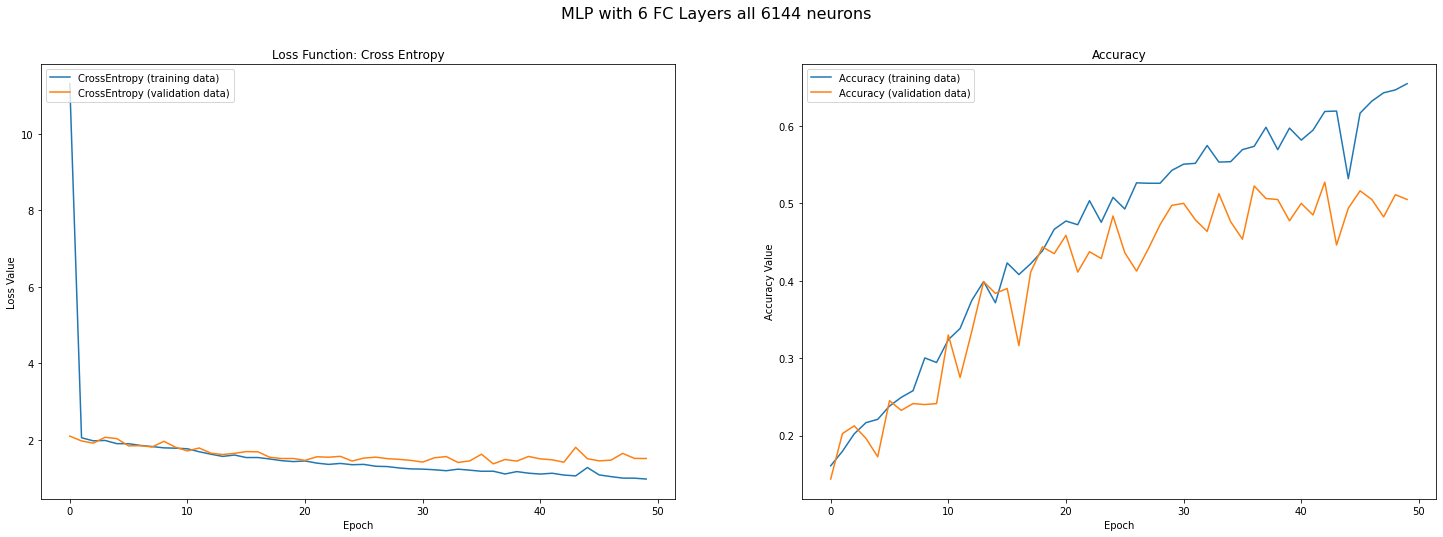

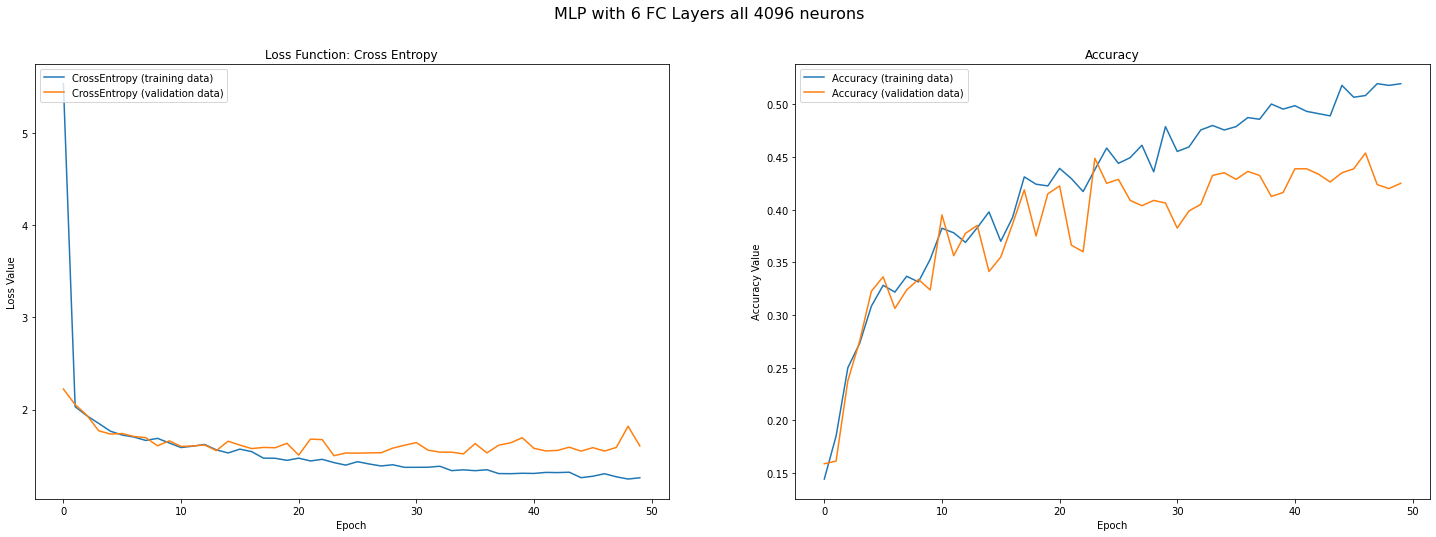

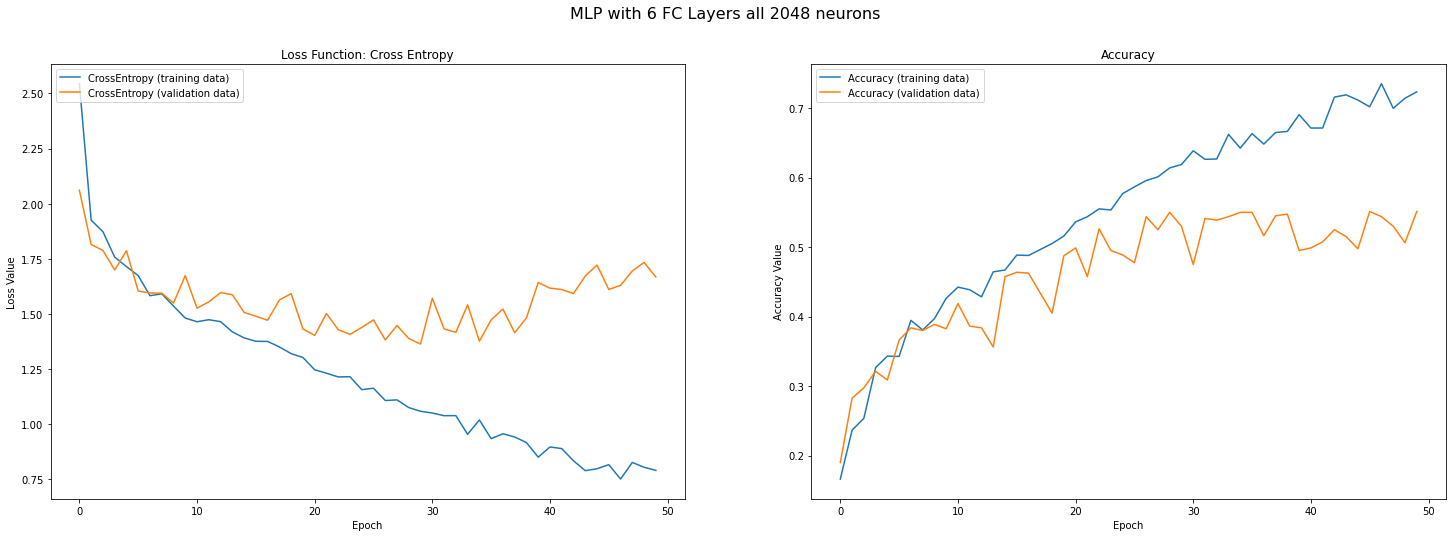

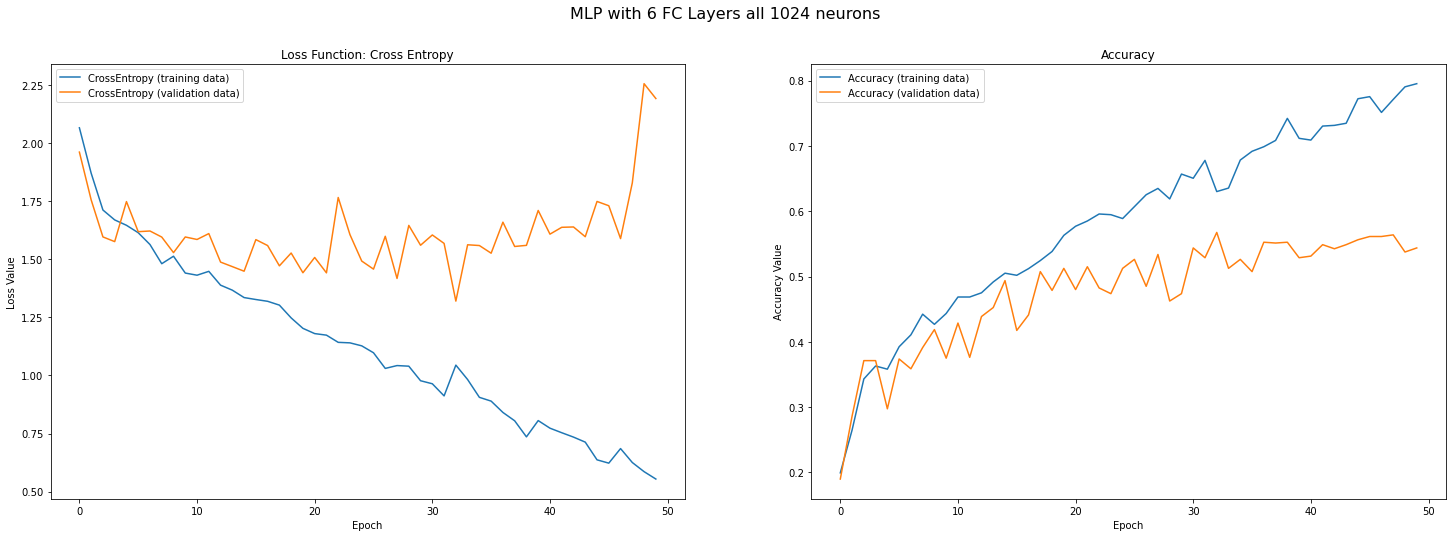

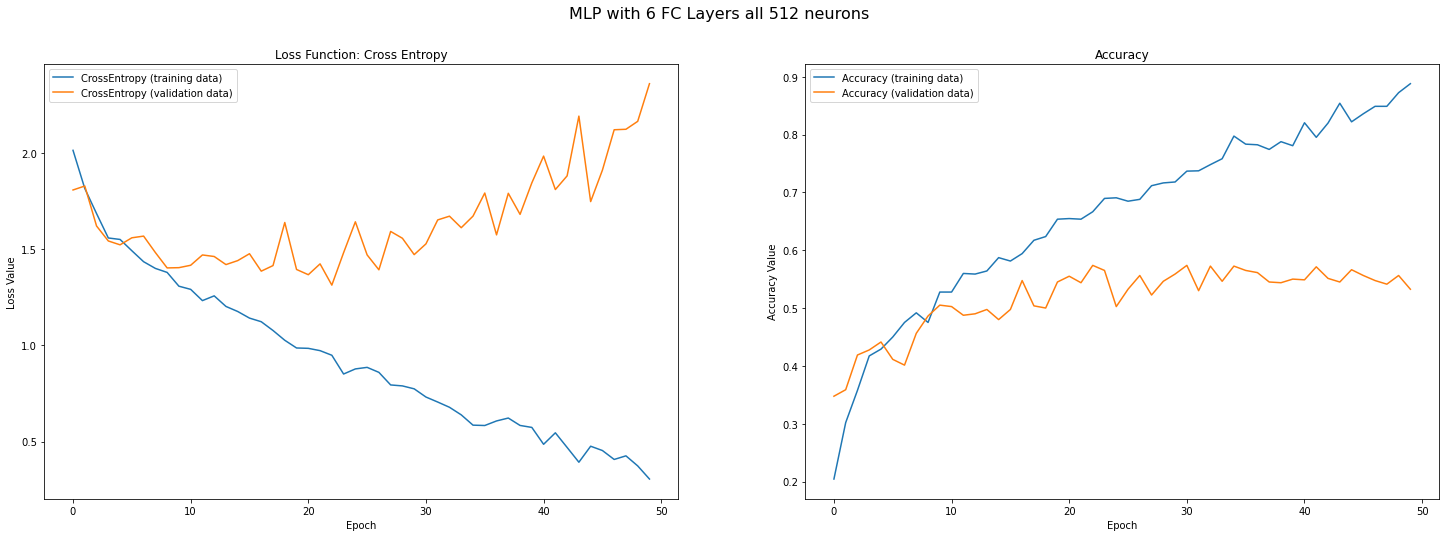

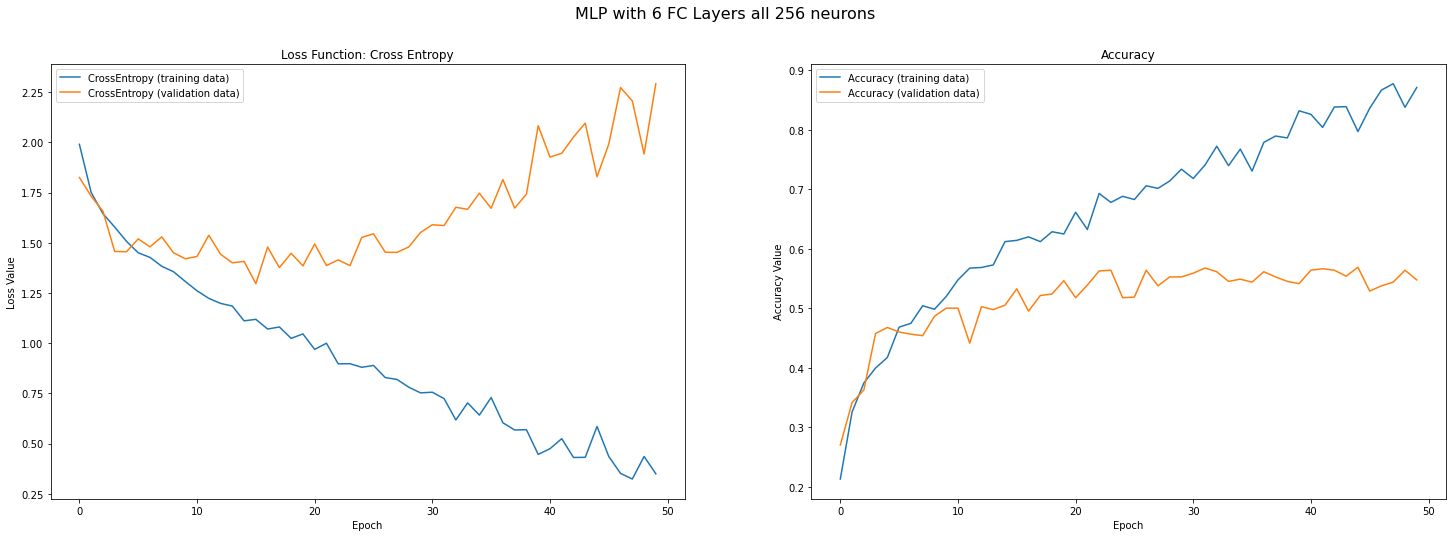

In [30]:
plot_loss_accuracy(history_6_big_6144, 'MLP with 6 FC Layers all 6144 neurons')
plot_loss_accuracy(history_6_big_4096, 'MLP with 6 FC Layers all 4096 neurons')
plot_loss_accuracy(history_6_big_2048, 'MLP with 6 FC Layers all 2048 neurons')
plot_loss_accuracy(history_6_big_1024, 'MLP with 6 FC Layers all 1024 neurons')
plot_loss_accuracy(history_6_big_512, 'MLP with 6 FC Layers all 512 neurons')
plot_loss_accuracy(history_6_big_256, 'MLP with 6 FC Layers all 256 neurons')

In [31]:
evaluate_model(model_6_big_6144, 'MLP with 6 FC Layers all 6144 neurons')
evaluate_model(model_6_big_4096, 'MLP with 6 FC Layers all 4096 neurons')
evaluate_model(model_6_big_2048, 'MLP with 6 FC Layers all 2048 neurons')
evaluate_model(model_6_big_1024, 'MLP with 6 FC Layers all 1024 neurons')
evaluate_model(model_6_big_512, 'MLP with 6 FC Layers all 512 neurons')
evaluate_model(model_6_big_256, 'MLP with 6 FC Layers all 256 neurons')

------------------------------------------------------------------------------------------
MLP with 6 FC Layers all 6144 neurons Train Score: 62.839 || Train Loss: 0.992
MLP with 6 FC Layers all 6144 neurons Test Score: 50.558 || Test Loss: 1.510
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
MLP with 6 FC Layers all 4096 neurons Train Score: 54.971 || Train Loss: 1.163
MLP with 6 FC Layers all 4096 neurons Test Score: 42.379 || Test Loss: 1.605
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
MLP with 6 FC Layers all 2048 neurons Train Score: 78.575 || Train Loss: 0.602
MLP with 6 FC Layers all 2048 neurons Test Score: 55.266 || Test Loss: 1.668
-----------------------------------------------------------------------------

### Conclusions
Following the same trend of the layers' study here we don't really see a big impact for number of neurons. The most performant was 512. We can see that equally to layers a very small or very big number of neurons also leads to bad performance, we need to choose a "proper" number of neurons per layer.

----------------------------------------------------------------------
* Now we are going to experiment with different images sizes using a 4 layer MLP

In [32]:
BATCH_SIZE = 16
IMG_SIZE = 16
train_loader, test_loader = get_datasets()
# 4 FC layers
model_6_16_x_16 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=512, activation='relu'), Dense(units=256, activation='relu'), Dense(units=256, activation='relu'), Dense(units=128, activation='relu', name="features")], 'model_6_16_x_16.png',IMG_SIZE=IMG_SIZE)
# Training
history_6_16_x_16 = model_6_16_x_16.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 768)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 2048)              1574912   
_________________________________________________________________
dense_76 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_77 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_78 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_79 (Dense)             (None, 256)               131328    
____________________________________

In [33]:
IMG_SIZE = 32
train_loader, test_loader = get_datasets()
# 4 FC layers
model_6_32_x_32 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=512, activation='relu'), Dense(units=256, activation='relu'), Dense(units=256, activation='relu'), Dense(units=128, activation='relu', name="features")], 'model_6_32_x_32.png',IMG_SIZE=IMG_SIZE)
# Training
history_6_32_x_32 = model_6_32_x_32.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_83 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_84 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_85 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_86 (Dense)             (None, 256)               131328    
____________________________________

In [34]:
IMG_SIZE = 48
train_loader, test_loader = get_datasets()
# 4 FC layers
model_6_48_x_48 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=512, activation='relu'), Dense(units=256, activation='relu'), Dense(units=256, activation='relu'), Dense(units=128, activation='relu', name="features")], 'model_6_48_x_48.png',IMG_SIZE=IMG_SIZE)
# Training
history_6_48_x_48 = model_6_48_x_48.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 6912)              0         
_________________________________________________________________
dense_89 (Dense)             (None, 2048)              14157824  
_________________________________________________________________
dense_90 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_91 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_92 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_93 (Dense)             (None, 256)               131328    
____________________________________

In [35]:
IMG_SIZE = 64
train_loader, test_loader = get_datasets()
# 4 FC layers
model_6_64_x_64 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=512, activation='relu'), Dense(units=256, activation='relu'), Dense(units=256, activation='relu'), Dense(units=128, activation='relu', name="features")], 'model_6_64_x_64.png',IMG_SIZE=IMG_SIZE)
# Training
history_6_64_x_64 = model_6_64_x_64.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 12288)             0         
_________________________________________________________________
dense_96 (Dense)             (None, 2048)              25167872  
_________________________________________________________________
dense_97 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_98 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_99 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_100 (Dense)            (None, 256)               131328    
____________________________________

In [36]:
IMG_SIZE = 96
train_loader, test_loader = get_datasets()
# 4 FC layers
model_6_96_x_96 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=512, activation='relu'), Dense(units=256, activation='relu'), Dense(units=256, activation='relu'), Dense(units=128, activation='relu', name="features")], 'model_6_84_x_84.png',IMG_SIZE=IMG_SIZE)
# Training
history_6_96_x_96 = model_6_96_x_96.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 27648)             0         
_________________________________________________________________
dense_103 (Dense)            (None, 2048)              56625152  
_________________________________________________________________
dense_104 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_105 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_106 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_107 (Dense)            (None, 256)               131328    
____________________________________

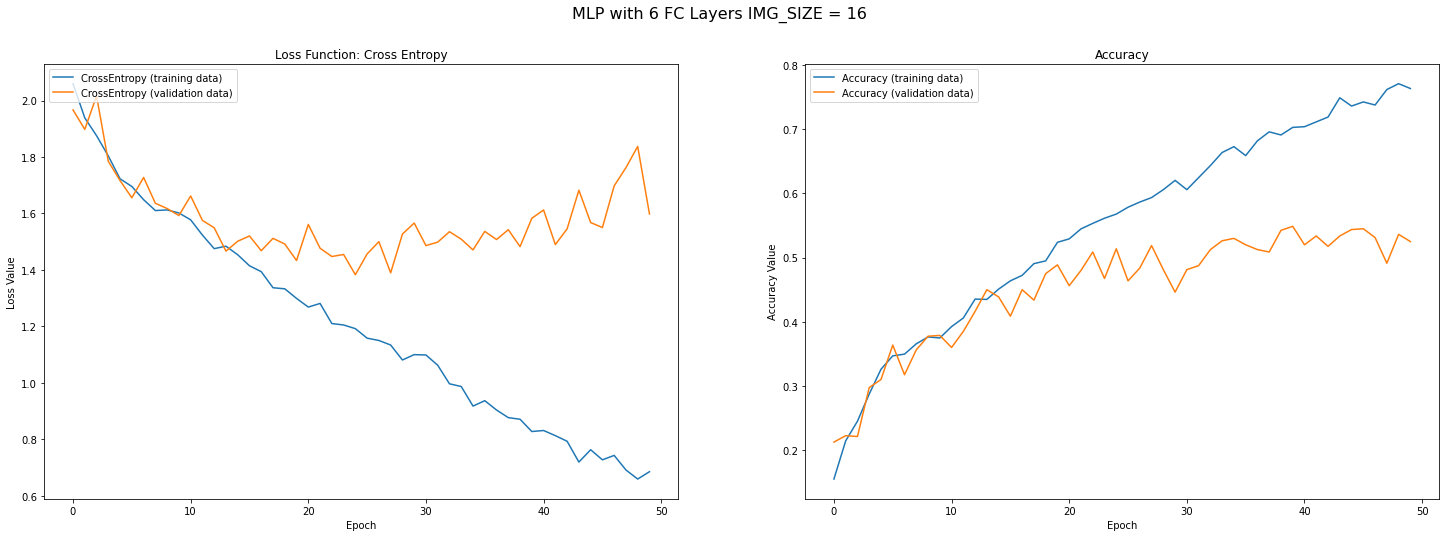

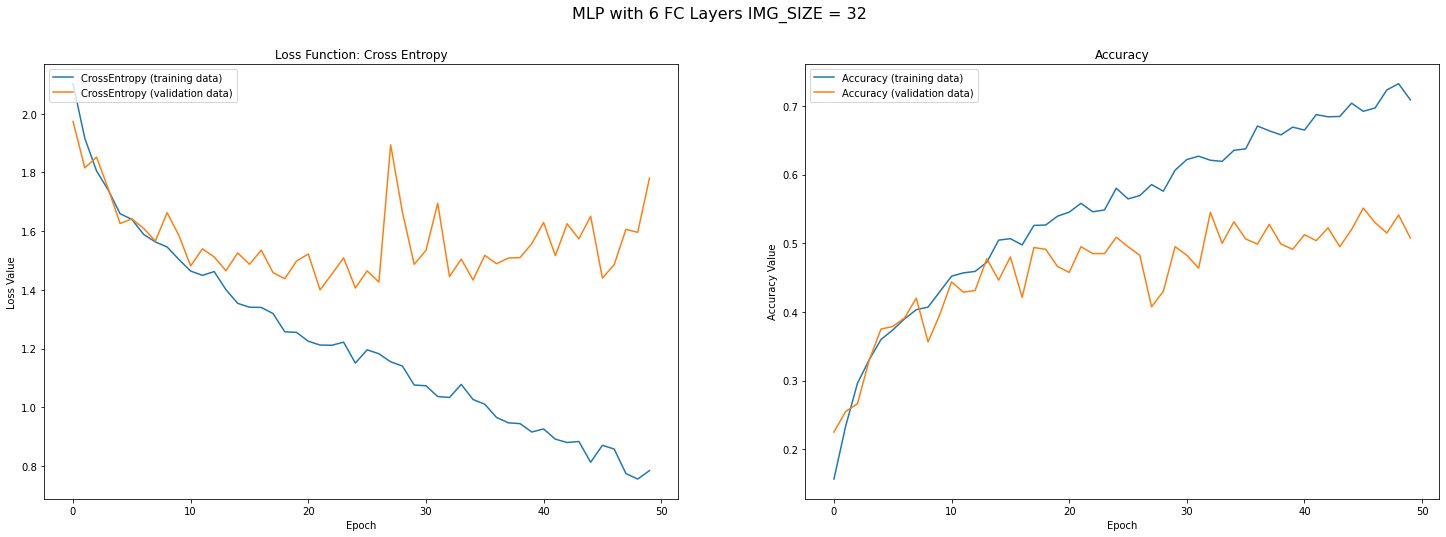

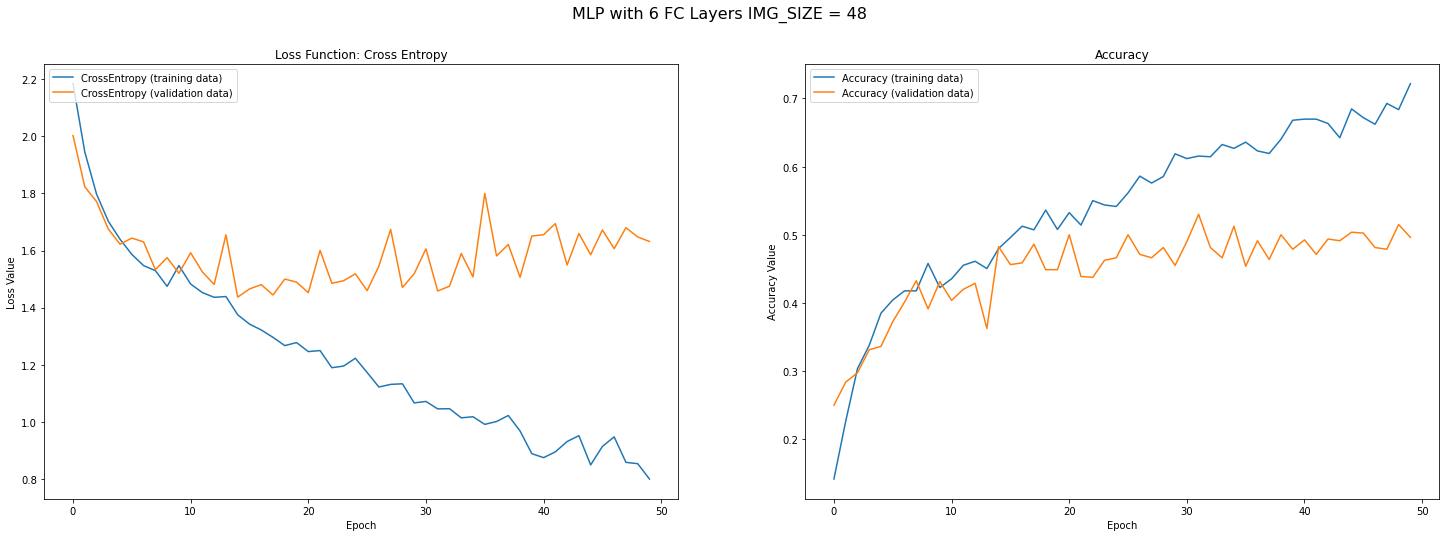

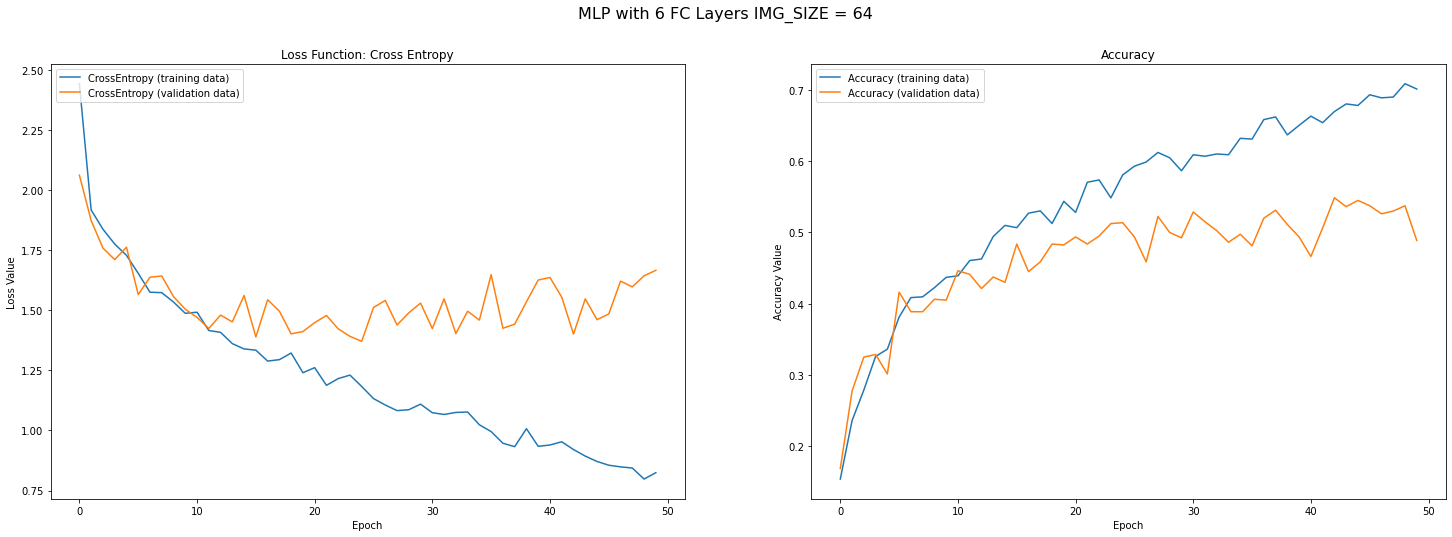

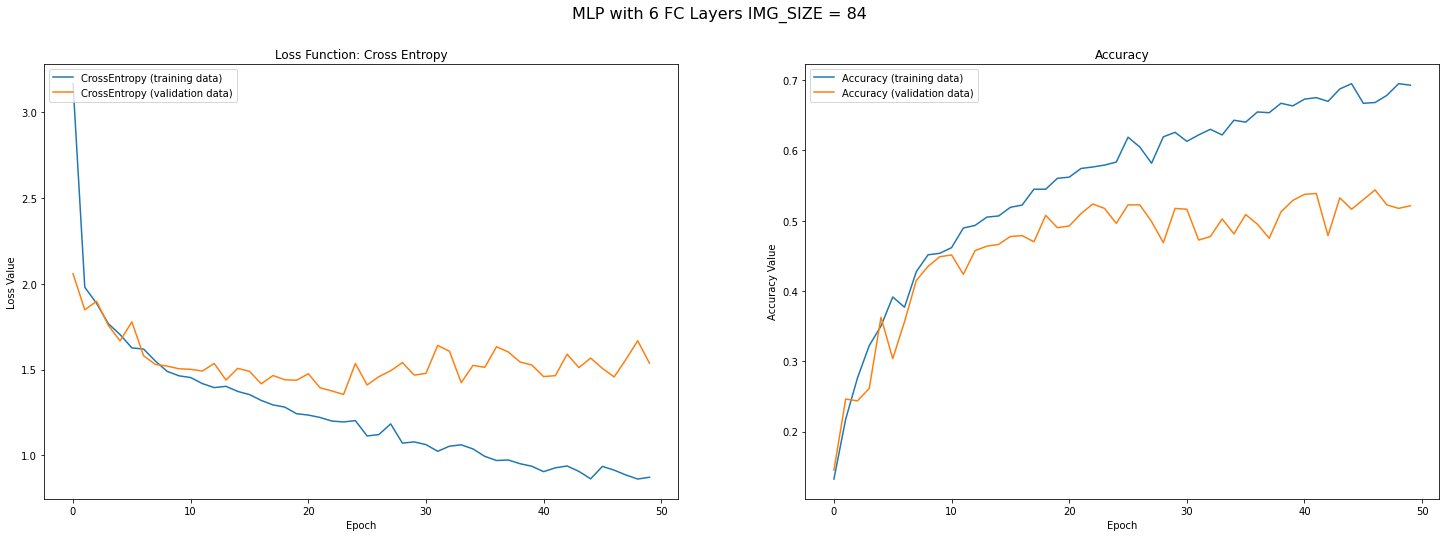

In [37]:
plot_loss_accuracy(history_6_16_x_16, 'MLP with 6 FC Layers IMG_SIZE = 16')
plot_loss_accuracy(history_6_32_x_32, 'MLP with 6 FC Layers IMG_SIZE = 32')
plot_loss_accuracy(history_6_48_x_48, 'MLP with 6 FC Layers IMG_SIZE = 48')
plot_loss_accuracy(history_6_64_x_64, 'MLP with 6 FC Layers IMG_SIZE = 64')
plot_loss_accuracy(history_6_96_x_96, 'MLP with 6 FC Layers IMG_SIZE = 84')

In [38]:
IMG_SIZE = 16
train_loader, test_loader = get_datasets()
evaluate_model(model_6_16_x_16, 'MLP with 6 FC Layers IMG_SIZE = 16')

IMG_SIZE = 32
train_loader, test_loader = get_datasets()
evaluate_model(model_6_32_x_32, 'MLP with 6 FC Layers IMG_SIZE = 32')

IMG_SIZE = 48
train_loader, test_loader = get_datasets()
evaluate_model(model_6_48_x_48, 'MLP with 6 FC Layers IMG_SIZE = 48')

IMG_SIZE = 64
train_loader, test_loader = get_datasets()
evaluate_model(model_6_64_x_64, 'MLP with 6 FC Layers IMG_SIZE = 64')

IMG_SIZE = 96
train_loader, test_loader = get_datasets()
evaluate_model(model_6_96_x_96, 'MLP with 6 FC Layers IMG_SIZE = 96')

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
------------------------------------------------------------------------------------------
MLP with 6 FC Layers IMG_SIZE = 16 Train Score: 79.266 || Train Loss: 0.606
MLP with 6 FC Layers IMG_SIZE = 16 Test Score: 52.416 || Test Loss: 1.600
------------------------------------------------------------------------------------------
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
------------------------------------------------------------------------------------------
MLP with 6 FC Layers IMG_SIZE = 32 Train Score: 67.251 || Train Loss: 0.938
MLP with 6 FC Layers IMG_SIZE = 32 Test Score: 50.805 || Test Loss: 1.780
------------------------------------------------------------------------------------------
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
---------------------------------------------------------------------------------------

### Conclusions
Todo

------------------------------------------------------------------------------------------------
To conclude the topology analysis we are going to check different batch sizes: smaller, medium, large and very large.

In [39]:
IMG_SIZE = 32
BATCH_SIZE = 8
train_loader, test_loader = get_datasets()
# 4 FC layers
model_4_b_8 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'), Dense(units=256, activation='relu', name="features")], 'model_4_b_8.png',IMG_SIZE=IMG_SIZE)
# Training
history_4_b_8 = model_4_b_8.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_110 (Dense)            (None, 2048)              6293504   
_________________________________________________________________
dense_111 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_112 (Dense)            (None, 512)               524800    
_________________________________________________________________
features (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_113 (Dense)            (None, 8)                 2056      
Total params: 9,049,864
Trainable pa

In [40]:
IMG_SIZE = 32
BATCH_SIZE = 64
train_loader, test_loader = get_datasets()
# 4 FC layers
model_4_b_64 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'), Dense(units=256, activation='relu', name="features")], 'model_4_b_64.png',IMG_SIZE=IMG_SIZE)
# Training
history_4_b_64 = model_4_b_64.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_114 (Dense)            (None, 2048)              6293504   
_________________________________________________________________
dense_115 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_116 (Dense)            (None, 512)               524800    
_________________________________________________________________
features (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_117 (Dense)            (None, 8)                 2056      
Total params: 9,049,864
Trainable pa

In [41]:
IMG_SIZE = 32
BATCH_SIZE = 256
train_loader, test_loader = get_datasets()
# 4 FC layers
model_4_b_256 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'), Dense(units=256, activation='relu', name="features")], 'model_4_b_256.png',IMG_SIZE=IMG_SIZE)
# Training
history_4_b_256 = model_4_b_256.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_118 (Dense)            (None, 2048)              6293504   
_________________________________________________________________
dense_119 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_120 (Dense)            (None, 512)               524800    
_________________________________________________________________
features (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_121 (Dense)            (None, 8)                 2056      
Total params: 9,049,864
Trainable pa

In [42]:
IMG_SIZE = 32
BATCH_SIZE = 512
train_loader, test_loader = get_datasets()
# 4 FC layers
model_4_b_512 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'), Dense(units=256, activation='relu', name="features")], 'model_4_b_512.png',IMG_SIZE=IMG_SIZE)
# Training
history_4_b_512 = model_4_b_512.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_122 (Dense)            (None, 2048)              6293504   
_________________________________________________________________
dense_123 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_124 (Dense)            (None, 512)               524800    
_________________________________________________________________
features (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_125 (Dense)            (None, 8)                 2056      
Total params: 9,049,864
Trainable pa

In [43]:
IMG_SIZE = 32
BATCH_SIZE = 807 # test size max
train_loader, test_loader = get_datasets()
# 4 FC layers
model_4_b_807 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'), Dense(units=256, activation='relu', name="features")], 'model_4_b_807.png',IMG_SIZE=IMG_SIZE)
# Training
history_4_b_807 = model_4_b_807.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_126 (Dense)            (None, 2048)              6293504   
_________________________________________________________________
dense_127 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_128 (Dense)            (None, 512)               524800    
_________________________________________________________________
features (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_129 (Dense)            (None, 8)                 2056      
Total params: 9,049,864
Trainable pa

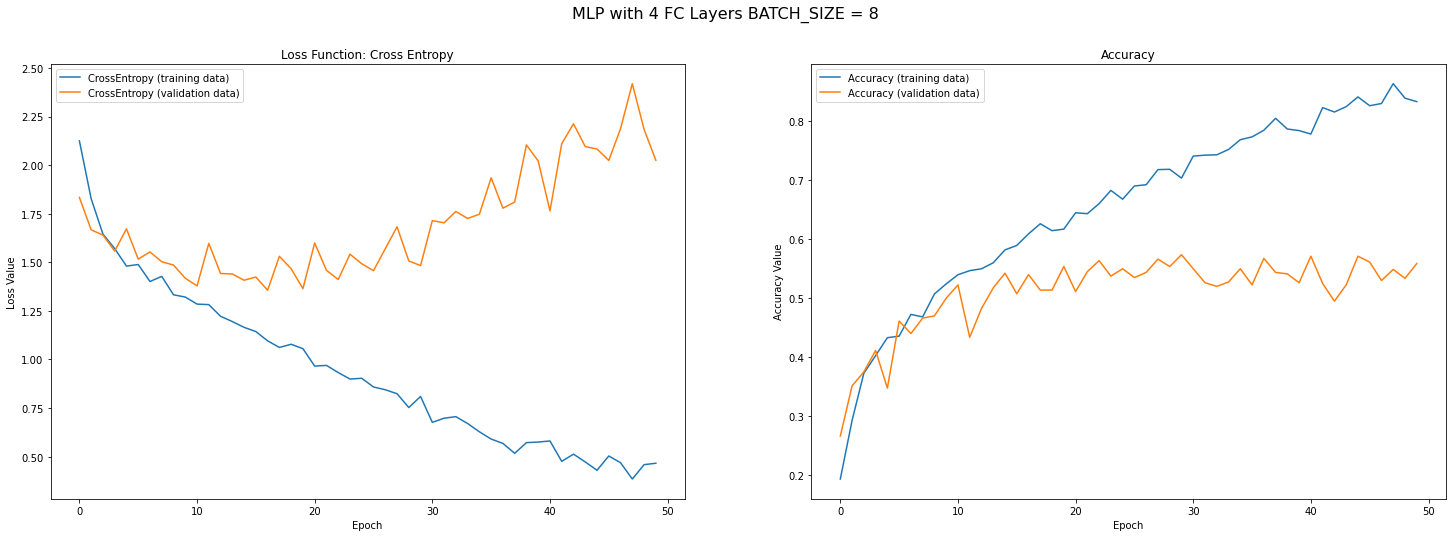

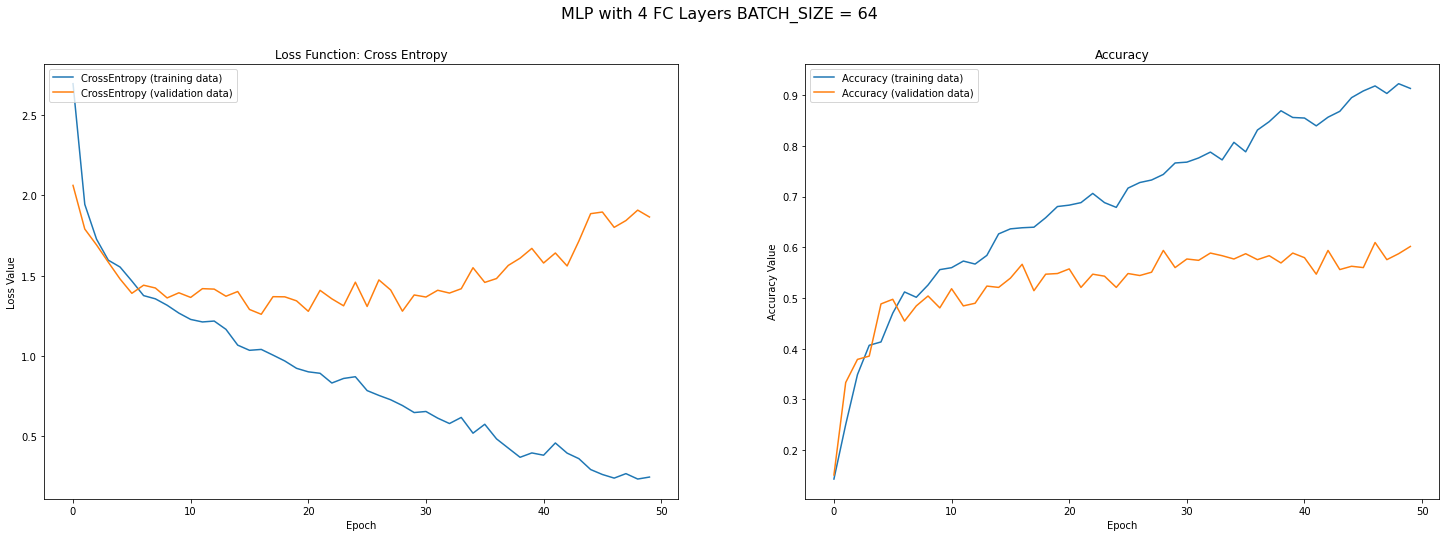

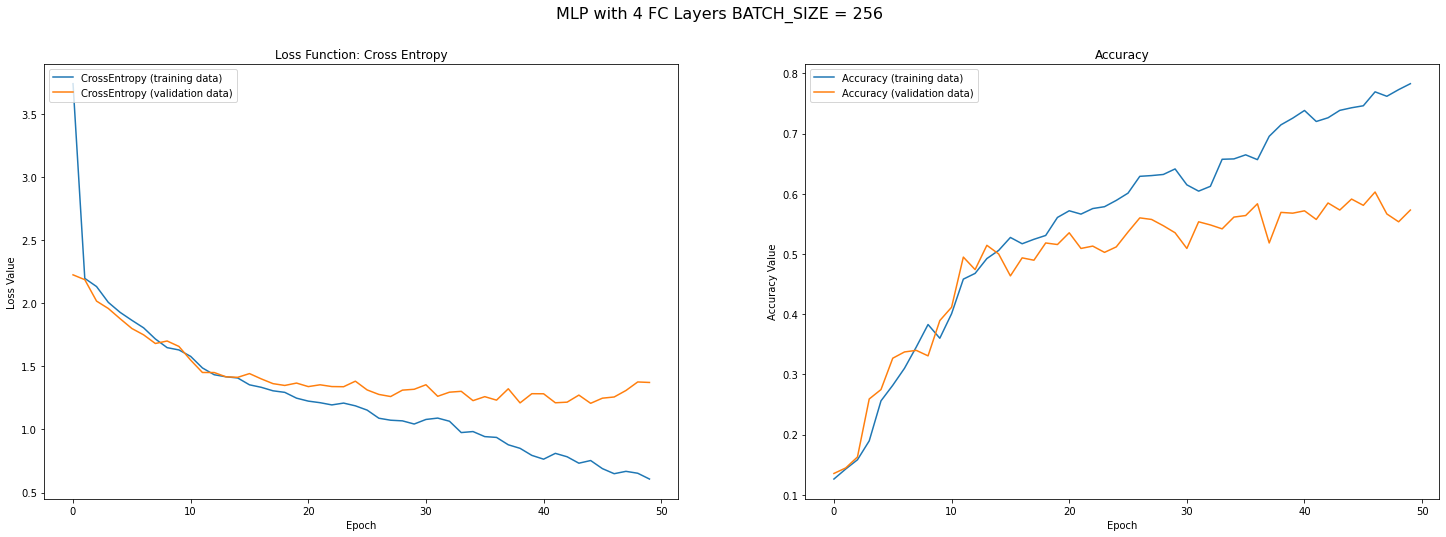

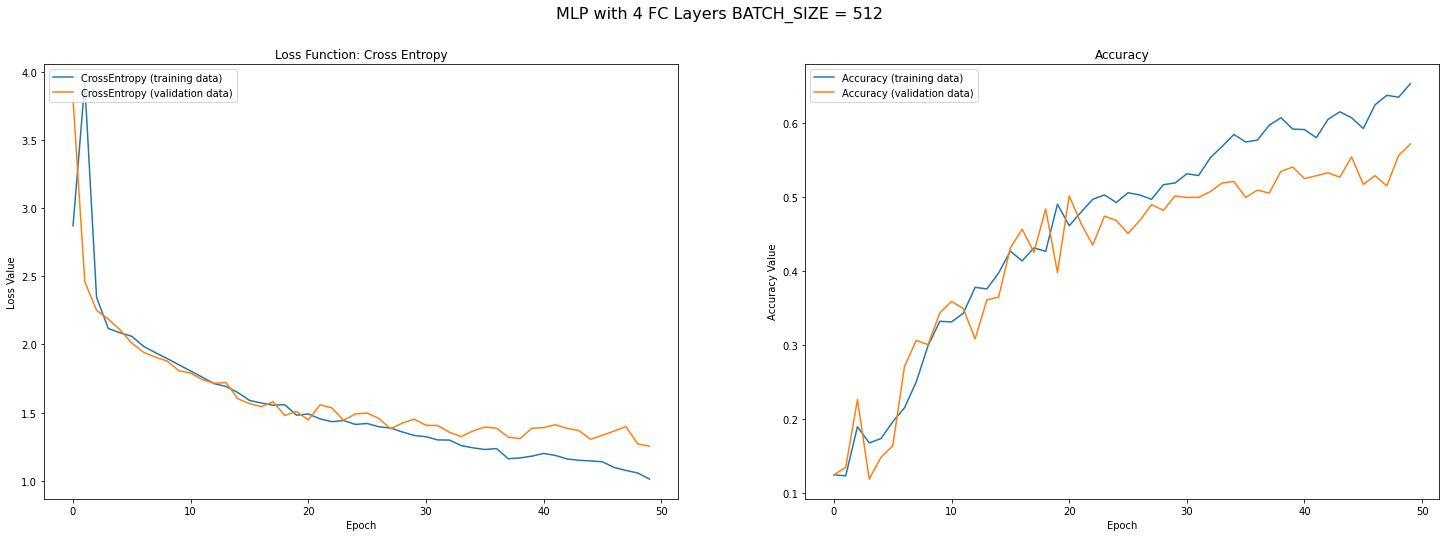

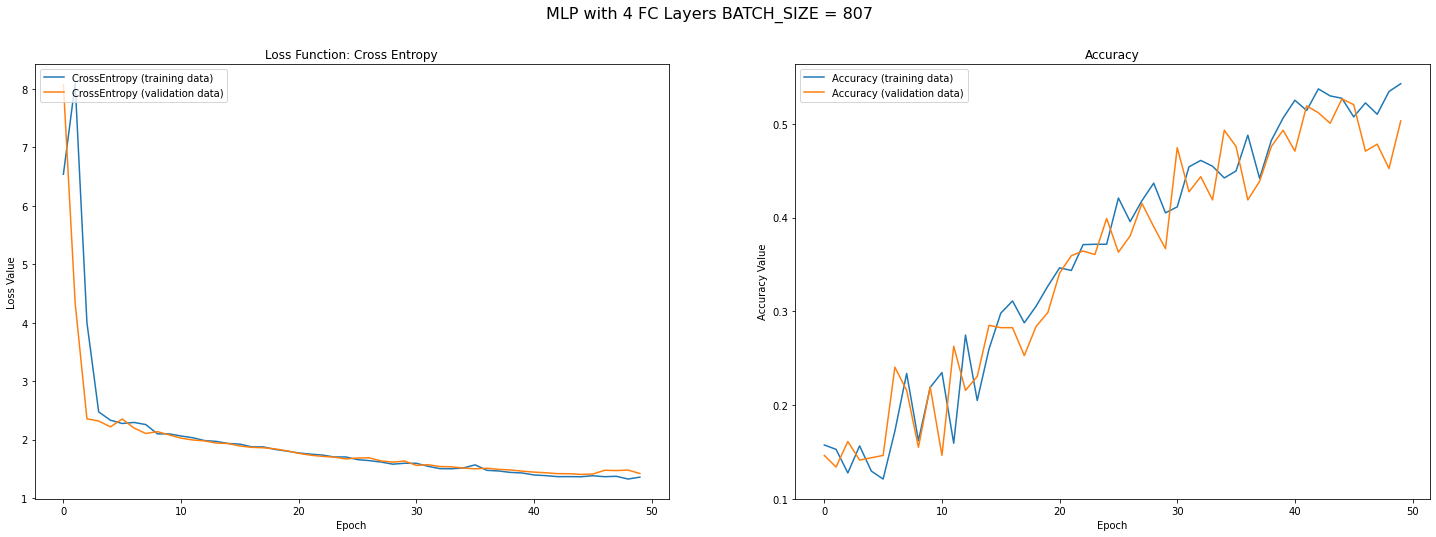

In [44]:
plot_loss_accuracy(history_4_b_8, 'MLP with 4 FC Layers BATCH_SIZE = 8')
plot_loss_accuracy(history_4_b_64, 'MLP with 4 FC Layers BATCH_SIZE = 64')
plot_loss_accuracy(history_4_b_256, 'MLP with 4 FC Layers BATCH_SIZE = 256')
plot_loss_accuracy(history_4_b_512, 'MLP with 4 FC Layers BATCH_SIZE = 512')
plot_loss_accuracy(history_4_b_807, 'MLP with 4 FC Layers BATCH_SIZE = 807')

In [45]:
BATCH_SIZE = 8
train_loader, test_loader = get_datasets()
evaluate_model(model_4_b_8, 'MLP with 4 FC Layers BATCH_SIZE = 8')

BATCH_SIZE = 64
train_loader, test_loader = get_datasets()
evaluate_model(model_4_b_64, 'MLP with 4 FC Layers BATCH_SIZE = 64')

BATCH_SIZE = 256
train_loader, test_loader = get_datasets()
evaluate_model(model_4_b_256, 'MLP with 4 FC Layers BATCH_SIZE = 256')

BATCH_SIZE = 512
train_loader, test_loader = get_datasets()
evaluate_model(model_4_b_512, 'MLP with 4 FC Layers BATCH_SIZE = 512')

BATCH_SIZE = 807
train_loader, test_loader = get_datasets()
evaluate_model(model_4_b_807, 'MLP with 4 FC Layers BATCH_SIZE = 807')

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
------------------------------------------------------------------------------------------
MLP with 4 FC Layers BATCH_SIZE = 8 Train Score: 87.347 || Train Loss: 0.366
MLP with 4 FC Layers BATCH_SIZE = 8 Test Score: 55.638 || Test Loss: 2.035
------------------------------------------------------------------------------------------
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
------------------------------------------------------------------------------------------
MLP with 4 FC Layers BATCH_SIZE = 64 Train Score: 91.760 || Train Loss: 0.247
MLP with 4 FC Layers BATCH_SIZE = 64 Test Score: 59.603 || Test Loss: 1.865
------------------------------------------------------------------------------------------
Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.
---------------------------------------------------------------------------------

### Conclusions

------------------------------------
### Evaluating Learnt features from NN for SVM
We are going to evaluate performance with learnt feature for both models. We are using MLP with 4 FC Layers BATCH_SIZE = 807 that performed the best

In [46]:
def get_features_from_trained_model(model, data):
    feature_network = Model(model.input, model.get_layer('features').output)
    feature = feature_network.predict(data)
    return feature


In [47]:
def generator_to_numpy(generator):
    generator.reset()
    gen_split = [generator.next() for i in range(generator.__len__())]
    x, y = map(list, zip(*gen_split))
    x, y = np.array(x), np.array(y)
    
    new_x = x[0]
    new_y = y[0]
    
    for i in range(1, len(x), 1):
        new_x = np.vstack((new_x, x[i]))
        new_y = np.vstack((new_y, y[i]))
    
    new_y = new_y.argmax(axis=1)
    new_y = new_y.reshape((len(new_y),))
    
    return new_x, new_y

In [62]:
!pip install numpy_ml
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from numpy_ml.neural_nets.losses import CrossEntropy

def evaluate_svm(estimator, params, cv, y_train, y_test):

    # Selecting best model params through GridSearchCV
    model = GridSearchCV(estimator = estimator,n_jobs = -1, param_grid = params, cv =cv)
    X_train = get_features_from_trained_model(model_4_b_807, train_loader)
    model.fit(X_train, y_train)
    print(model.best_params_)

    # Evaluate model on test set
    X_test = get_features_from_trained_model(model_4_b_807, test_loader)
    test_score = model.score(X_test, y_test)
    train_score = model.score(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    n_values = np.max(y_train) + 1
    y_train = np.eye(n_values)[y_train]
    
    n_values = np.max(y_test) + 1
    y_test = np.eye(n_values)[y_test]
    
    n_values = np.max(y_test_pred) + 1
    y_test_pred = np.eye(n_values)[y_test_pred]
    
    n_values = np.max(y_train_pred) + 1
    y_train_pred = np.eye(n_values)[y_train_pred]
    
    test_loss = CrossEntropy.loss(y_test,y_test_pred)
    train_loss = CrossEntropy.loss(y_train,y_train_pred)


    print("SVM with Learnt Features -> Train Score: {:.3f} Test Score: {:.3f}".format(100*train_score,100*test_score))
    print("SVM with Learnt Features -> Train Loss: {:.3f} Test Loss: {:.3f}".format(train_loss,test_loss))

In [63]:
params = {"kernel": ["rbf", "linear"], "gamma": [0.1, 1, 10, 100], "C": [1e-3, 1e-2, 1e-1, 1, 5, 10, 20, 50],"tol": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5], "random_state": [RANDOM_SEED]}
X_train, y_train = generator_to_numpy(train_loader)
X_test, y_test = generator_to_numpy(test_loader)
evaluate_svm(estimator = SVC(), params = params, cv = 3, y_train = y_train, y_test = y_test)

C:\Users\Yusep\AppData\Local\Temp/ipykernel_16160/3302751483.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x, y = np.array(x), np.array(y)


{'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 42, 'tol': 0.01}
SVM with Learnt Features -> Train Score: 67.624 Test Score: 56.010
SVM with Learnt Features -> Train Loss: 21950.585 Test Loss: 12795.497
